# Cellular automaton 

## Test file for experiments with many percolation threshold

##### Colin Decourt - Bordeaux INP ENSEIRB-MATMECA
Engineering student in artificial intelligence


###### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import datetime
import cv2 as cv
from tqdm import tqdm
import seaborn as sb
%matplotlib inline

##### Utils functions

In [2]:
def create_gif(filenames, duration, path):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = 'Gif-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave(path+output_file, images, duration=duration)

In [3]:
def get_neighbours_indices(forest, cell, valid_cells):
    '''
    Function which get all the valid neighbours of a given cell
    :forest: the forest grid
    :cell: cell's neighbours
    :valid_cells: all the valid coordinates of the forest grid
    '''
    X = [-1, -1, 0, 1, 1, 1, 0, -1]
    Y = [0, 1, 1, 1, 0, -1, -1, -1]
    neighbours_list = []
    
    for k in range(len(X)):
        temp_cell = (cell[0] + X[k], cell[1] + Y[k])
        if temp_cell in valid_cells:
            neighbours_list.append(temp_cell)
    return neighbours_list
            

In [4]:
def valid_cells(forest):
    '''
    Function which get all the coordinates of the grid
    :forest: the forest grid
    '''
    valid_cells = []
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            valid_cells.append((i,j))
    return valid_cells

##### Parameters

In [6]:
cells = {'empty':0, 'tree':1, 'fire': 2, 'ash': 3}

grid_size = (100, 100)

# Display parameters
pallette = np.array( [[153, 102, 0],# empty
                      [0, 51, 8],  # tree
                      [230, 115, 0],   # fire
                      [158, 158, 158] # ash
                      ])

In [7]:
def generate_forest(grid_size, density):
    grid = np.random.choice(3, grid_size[0]*grid_size[0] , p = [1-density, density, 0]).reshape(grid_size)
    valid = valid_cells(grid)
    tree=0
    fire = 0
    grid[int(grid_size[0]/2), int(grid_size[1]/2)] = cells['fire']
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i,j] == 1:
                tree +=1
            if grid[i,j] == 2:
                fire += 1
    initial_forest = {'fire': fire, 'tree':tree}
    return grid, initial_forest

##### Transition functions

Transition rules : 

- An empty cell stay empty
- A ash cell stay ash
- A fire cell become ash
- A tree cell :
    - Become fire if one of them neighbour is in fire
    - Stay tree otherwise

In [8]:
def may_burn(forest, cell, cell_type, state):
    to_burn = []
    no_burn = []

    neigh_list = get_neighbours_indices(forest, cell, EXIST_CELLS)
    for neigh_cell in neigh_list:
        if forest[neigh_cell] == cells['fire']:
            to_burn.append(neigh_cell)       
        else:
            no_burn.append(neigh_cell)
    if to_burn == []:
        return cells[cell_type], state
    else:
        state[cell_type]-=1
        state['fire'] += 1
        return cells['fire'], state

In [9]:
def transition_general(forest, cell, state):
    '''
    Function which return the future state of a given cell
    :forest: the forest grid
    :cell: cell's future state wanted
    :state: state of the country at current step
    '''
    try:
        if forest[cell] == cells['empty']:
            return cells['empty'], state

        if forest[cell] == cells['ash']:
            return cells['ash'], state

        if forest[cell] == cells['tree']:
            return may_burn(forest, cell, 'tree', state)

        if forest[cell] == cells['fire']:
            state['fire']-=1
            return cells['ash'], state
        
    except:
        print('Unknown cell type. Abort.')
    
    

##### Fire propagation

In [10]:
def step(forest, is_fire, state):
    '''
    Function which perfom one propagation step
    :forest: the forest grid
    :is_fire: boolean informing the fire state - True : still cell in fire False otherwise
    '''
    nb_fire = 0
    new_forest = forest.copy()
    new_state = state.copy()
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            cell_type, new_state = transition_general(forest, (i,j), new_state)
            new_forest[i,j] = cell_type
            if new_forest[i,j] == cells['fire']:
                nb_fire += 1
    print(nb_fire)
    if nb_fire == 0:
        is_fire = False
    return new_forest, is_fire, new_state

In [11]:
# Reset images
for name in os.listdir():
    if name[-3:] == 'png':
        if name != 'aust-veg-map.png':
            os.remove(name)

## Fire forest on random grid

In [16]:
densities = np.arange(0,1, 0.05)

for i in densities:
    density = {'tree': i}
    forest, initial_state = generate_forest((50,50), i)
    EXIST_CELLS = valid_cells(forest)
    is_fire = True
    state_list =[]
    state_list.append(initial_state)
    num_step = 0
    plt.figure(figsize=(10,10))
    plt.imshow(pallette[forest])
    plt.title('Grid 50x50 - Epoch n°'+str(num_step))
    plt.savefig(str(num_step)+'.png')
    plt.clf()
    while(1):
        print('--- STEP',num_step,'begin ---')
        forest, is_fire, state = step(forest, is_fire, state_list[num_step])
        print('New state:',state)
        state_list.append(state.copy())
        num_step+=1
        plt.figure(figsize=(10,10))
        plt.imshow(pallette[forest])
        plt.title('Grid 50x50 - Epoch n°'+str(num_step))
        plt.savefig(str(num_step)+'.png')
        plt.clf()
        if is_fire is False:
            print('Fire is dead...')
            break
    np.save('./percolation_data/state_list/state_list_'+str(i), state_list)
    filenames = []
    for name in os.listdir():
        if name[-3:] == 'png':
            if name != 'aust-veg-map.png':
                filenames.append(name)
    filenames.sort(key=lambda x: float(x[:-4]))

    create_gif(filenames, duration=0.8, name='./gif/'+str(grid_size))
    # Reset images
    for name in os.listdir():
        if name[-3:] == 'png':
            if name != 'aust-veg-map.png':
                os.remove(name)

--- STEP 0 begin ---
0
New state: {'fire': 0, 'tree': 0}
Fire is dead...
--- STEP 0 begin ---
0
New state: {'fire': 0, 'tree': 129}
Fire is dead...
--- STEP 0 begin ---
2
New state: {'fire': 2, 'tree': 241}
--- STEP 1 begin ---
0
New state: {'fire': 0, 'tree': 241}
Fire is dead...
--- STEP 0 begin ---
0
New state: {'fire': 0, 'tree': 378}
Fire is dead...
--- STEP 0 begin ---
0
New state: {'fire': 0, 'tree': 464}
Fire is dead...
--- STEP 0 begin ---
2
New state: {'fire': 2, 'tree': 632}
--- STEP 1 begin ---
4
New state: {'fire': 4, 'tree': 628}
--- STEP 2 begin ---
2
New state: {'fire': 2, 'tree': 626}
--- STEP 3 begin ---
1
New state: {'fire': 1, 'tree': 625}
--- STEP 4 begin ---
2
New state: {'fire': 2, 'tree': 623}
--- STEP 5 begin ---
0
New state: {'fire': 0, 'tree': 623}
Fire is dead...
--- STEP 0 begin ---
3
New state: {'fire': 3, 'tree': 742}
--- STEP 1 begin ---
2
New state: {'fire': 2, 'tree': 740}


/home/laurenbacal/anaconda3/envs/ia/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- STEP 2 begin ---
0
New state: {'fire': 0, 'tree': 740}
Fire is dead...


/home/laurenbacal/anaconda3/envs/ia/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


--- STEP 0 begin ---
4
New state: {'fire': 4, 'tree': 879}
--- STEP 1 begin ---
3
New state: {'fire': 3, 'tree': 876}
--- STEP 2 begin ---
3
New state: {'fire': 3, 'tree': 873}
--- STEP 3 begin ---
3
New state: {'fire': 3, 'tree': 870}
--- STEP 4 begin ---
3
New state: {'fire': 3, 'tree': 867}
--- STEP 5 begin ---
5
New state: {'fire': 5, 'tree': 862}
--- STEP 6 begin ---
7
New state: {'fire': 7, 'tree': 855}
--- STEP 7 begin ---
8
New state: {'fire': 8, 'tree': 847}
--- STEP 8 begin ---
9
New state: {'fire': 9, 'tree': 838}
--- STEP 9 begin ---
8
New state: {'fire': 8, 'tree': 830}
--- STEP 10 begin ---
9
New state: {'fire': 9, 'tree': 821}
--- STEP 11 begin ---
8
New state: {'fire': 8, 'tree': 813}
--- STEP 12 begin ---
5
New state: {'fire': 5, 'tree': 808}
--- STEP 13 begin ---
9
New state: {'fire': 9, 'tree': 799}
--- STEP 14 begin ---
6
New state: {'fire': 6, 'tree': 793}
--- STEP 15 begin ---
6
New state: {'fire': 6, 'tree': 787}
--- STEP 16 begin ---
5
New state: {'fire': 5, 'tr

--- STEP 39 begin ---
3
New state: {'fire': 3, 'tree': 244}
--- STEP 40 begin ---
5
New state: {'fire': 5, 'tree': 239}
--- STEP 41 begin ---
4
New state: {'fire': 4, 'tree': 235}
--- STEP 42 begin ---
5
New state: {'fire': 5, 'tree': 230}
--- STEP 43 begin ---
5
New state: {'fire': 5, 'tree': 225}
--- STEP 44 begin ---
5
New state: {'fire': 5, 'tree': 220}
--- STEP 45 begin ---
6
New state: {'fire': 6, 'tree': 214}
--- STEP 46 begin ---
5
New state: {'fire': 5, 'tree': 209}
--- STEP 47 begin ---
5
New state: {'fire': 5, 'tree': 204}
--- STEP 48 begin ---
4
New state: {'fire': 4, 'tree': 200}
--- STEP 49 begin ---
1
New state: {'fire': 1, 'tree': 199}
--- STEP 50 begin ---
2
New state: {'fire': 2, 'tree': 197}
--- STEP 51 begin ---
4
New state: {'fire': 4, 'tree': 193}
--- STEP 52 begin ---
3
New state: {'fire': 3, 'tree': 190}
--- STEP 53 begin ---
2
New state: {'fire': 2, 'tree': 188}
--- STEP 54 begin ---
2
New state: {'fire': 2, 'tree': 186}
--- STEP 55 begin ---
1
New state: {'fir

Fire is dead...
--- STEP 0 begin ---
7
New state: {'fire': 7, 'tree': 1593}
--- STEP 1 begin ---
8
New state: {'fire': 8, 'tree': 1585}
--- STEP 2 begin ---
12
New state: {'fire': 12, 'tree': 1573}
--- STEP 3 begin ---
19
New state: {'fire': 19, 'tree': 1554}
--- STEP 4 begin ---
21
New state: {'fire': 21, 'tree': 1533}
--- STEP 5 begin ---
26
New state: {'fire': 26, 'tree': 1507}
--- STEP 6 begin ---
31
New state: {'fire': 31, 'tree': 1476}
--- STEP 7 begin ---
40
New state: {'fire': 40, 'tree': 1436}
--- STEP 8 begin ---
40
New state: {'fire': 40, 'tree': 1396}
--- STEP 9 begin ---
40
New state: {'fire': 40, 'tree': 1356}
--- STEP 10 begin ---
45
New state: {'fire': 45, 'tree': 1311}
--- STEP 11 begin ---
53
New state: {'fire': 53, 'tree': 1258}
--- STEP 12 begin ---
65
New state: {'fire': 65, 'tree': 1193}
--- STEP 13 begin ---
71
New state: {'fire': 71, 'tree': 1122}
--- STEP 14 begin ---
63
New state: {'fire': 63, 'tree': 1059}
--- STEP 15 begin ---
68
New state: {'fire': 68, 'tre

75
New state: {'fire': 75, 'tree': 1683}
--- STEP 11 begin ---
84
New state: {'fire': 84, 'tree': 1599}
--- STEP 12 begin ---
82
New state: {'fire': 82, 'tree': 1517}
--- STEP 13 begin ---
88
New state: {'fire': 88, 'tree': 1429}
--- STEP 14 begin ---
106
New state: {'fire': 106, 'tree': 1323}
--- STEP 15 begin ---
111
New state: {'fire': 111, 'tree': 1212}
--- STEP 16 begin ---
114
New state: {'fire': 114, 'tree': 1098}
--- STEP 17 begin ---
115
New state: {'fire': 115, 'tree': 983}
--- STEP 18 begin ---
130
New state: {'fire': 130, 'tree': 853}
--- STEP 19 begin ---
136
New state: {'fire': 136, 'tree': 717}
--- STEP 20 begin ---
144
New state: {'fire': 144, 'tree': 573}
--- STEP 21 begin ---
151
New state: {'fire': 151, 'tree': 422}
--- STEP 22 begin ---
160
New state: {'fire': 160, 'tree': 262}
--- STEP 23 begin ---
154
New state: {'fire': 154, 'tree': 108}
--- STEP 24 begin ---
90
New state: {'fire': 90, 'tree': 18}
--- STEP 25 begin ---
16
New state: {'fire': 16, 'tree': 2}
--- ST

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

### Data analyse

In [22]:
def get_data(data):
    fire_list = []
    tree_list = []
    for i in range(len(data)):
        fire_list.append(data[i]['fire'])
        tree_list.append(data[i]['tree'])
    return tree_list, fire_list

In [27]:
def get_burned_trees(tree_list):
    if tree_list == []:
        return 0
    burn_list = (tree_list[0]-tree_list[-1])*100/(tree_list[0]+0.0001)
    return burn_list

def get_remain_trees(tree_list):
    if tree_list == []:
        return 0
    remain_list = (tree_list[-1])*100/(tree_list[0]+0.0001)
    return remain_list

In [24]:
grid0 = get_data(np.load('percolation_data/data/state_list_0.0.npy', allow_pickle=True))
grid0_05 = get_data(np.load('percolation_data/data/state_list_0.05.npy', allow_pickle=True))
grid0_1 = get_data(np.load('percolation_data/data/state_list_0.1.npy', allow_pickle=True))
grid0_15 = get_data(np.load('percolation_data/data/state_list_0.15000000000000002.npy', allow_pickle=True))
grid0_2 = get_data(np.load('percolation_data/data/state_list_0.2.npy', allow_pickle=True))
grid0_25 = get_data(np.load('percolation_data/data/state_list_0.25.npy', allow_pickle=True))
grid0_3 = get_data(np.load('percolation_data/data/state_list_0.30000000000000004.npy', allow_pickle=True))
grid0_35 = get_data(np.load('percolation_data/data/state_list_0.35000000000000003.npy', allow_pickle=True))
grid0_4 = get_data(np.load('percolation_data/data/state_list_0.4.npy', allow_pickle=True))
grid0_45 = get_data(np.load('percolation_data/data/state_list_0.45.npy', allow_pickle=True))
grid0_5 = get_data(np.load('percolation_data/data/state_list_0.5.npy', allow_pickle=True))
grid0_55 = get_data(np.load('percolation_data/data/state_list_0.55.npy', allow_pickle=True))
grid0_6 = get_data(np.load('percolation_data/data/state_list_0.6000000000000001.npy', allow_pickle=True))
grid0_65 = get_data(np.load('percolation_data/data/state_list_0.65.npy', allow_pickle=True))
grid0_7 = get_data(np.load('percolation_data/data/state_list_0.7000000000000001.npy', allow_pickle=True))
grid0_75 = get_data(np.load('tpercolation_data/data/state_list_0.75.npy', allow_pickle=True))
grid0_8 = get_data(np.load('percolation_data/data/state_list_0.8.npy', allow_pickle=True))
grid0_85 = get_data(np.load('percolation_data/data/state_list_0.8500000000000001.npy', allow_pickle=True))
grid0_9 = get_data(np.load('percolation_data/data/state_list_0.9.npy', allow_pickle=True))
grid0_95 = get_data(np.load('percolation_data/data/state_list_0.9500000000000001.npy', allow_pickle=True))

In [28]:
tree_per_dens = [grid0, grid0_05, grid0_1, grid0_15,
                grid0_2, grid0_25, grid0_3, grid0_35,
                grid0_4, grid0_45, grid0_5, grid0_55,
                grid0_6, grid0_65, grid0_7, grid0_75,
                grid0_8, grid0_85, grid0_9, grid0_95]

burn_trees = [get_burned_trees(tree_per_dens[i][0]) for i in range(len(tree_per_dens))]
remain_trees = [get_remain_trees(tree_per_dens[i][0]) for i in range(len(tree_per_dens))]

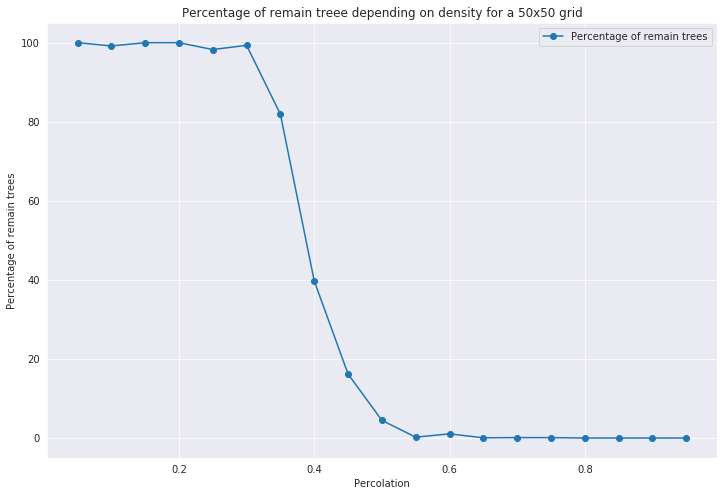

In [31]:
plt.figure(figsize=(12,8))
sb.set_style('darkgrid')
plt.plot(densities[1:], remain_trees[1:], '-o')
plt.xlabel('Percolation')
plt.ylabel('Percentage of remain trees')
plt.title('Percentage of remain treee depending on density for a 50x50 grid')
plt.legend(('Percentage of remain trees',))
plt.savefig('./percolation_data/real_remain_tree_density.png')
plt.show()

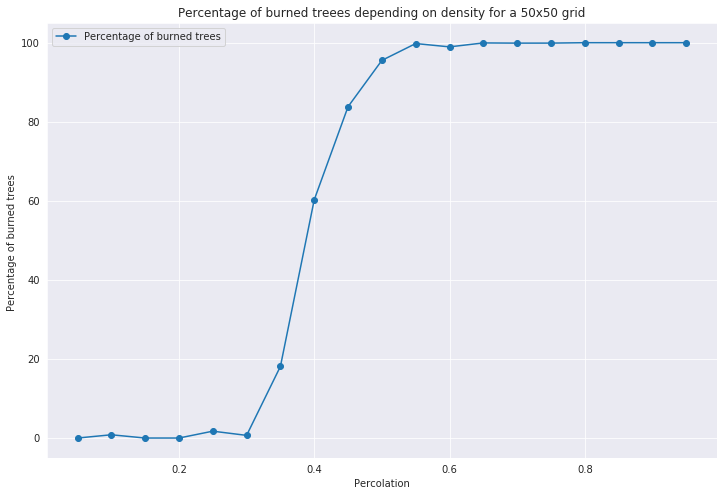

In [32]:
plt.figure(figsize=(12,8))
sb.set_style('darkgrid')
plt.plot(densities[1:], burn_trees[1:], '-o')
plt.xlabel('Percolation')
plt.ylabel('Percentage of burned trees ')
plt.title('Percentage of burned treees depending on density for a 50x50 grid')
plt.legend(('Percentage of burned trees',), loc='upper left')
plt.savefig('./percolation_data/real_burned_tree_density.png')
plt.show()